In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [9]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import time
from pathlib import Path
import pytesseract
from PIL import Image
from tqdm.autonotebook import tqdm
from functools import reduce
import operator 

def imshow(x):
    fig = plt.figure()
    plt.imshow(x)
    return fig

frames_dir = Path('/home/francesco/Documents/Kanga-Challenge/source/dataset/videos/evo2014/frames/')

In [107]:
import shutil

paths = list(frames_dir.glob('*.jpg'))
paths.sort(key=lambda a: int(a.name.split('.')[0]))
out_path = '/home/francesco/Documents/Kanga-Challenge/source/dataset/yolo/frames/'
for i, path in enumerate(paths):
    if i % 10 == 0:
        shutil.copy(str(path), f'{out_path}{i}.jpg')

## Exploring Traces
Text will usually be present in at least 3/4 frames since it has to be read by humans. We can try to see if we are able to mask it correctly

In [6]:
from data import VideoDataset
from torch.utils.data import DataLoader, random_split

In [7]:
def imread_convert(x):
    x = cv2.imread(str(x))
    if x is not None:
        x = cv2.resize(x, (320, 320))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    return x

paths = list(frames_dir.glob('*.jpg'))
paths.sort(key=lambda a: int(a.name.split('.')[0]))
frames = list(tqdm(map(imread_convert, paths)))


<IPython.core.display.Javascript object>


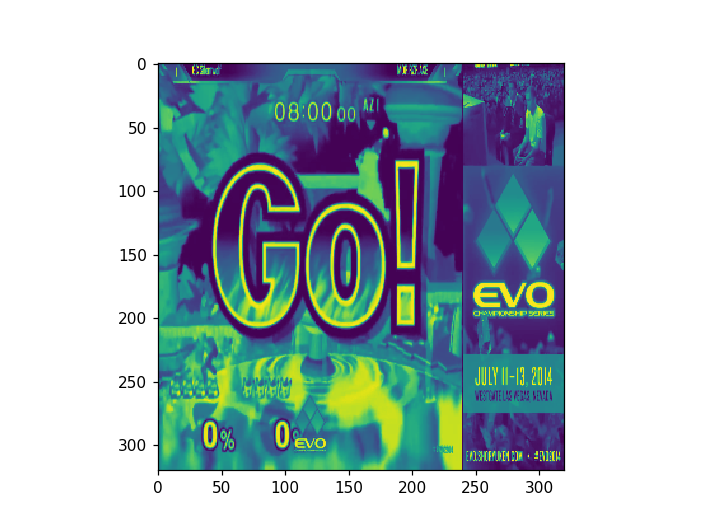

<IPython.core.display.Javascript object>


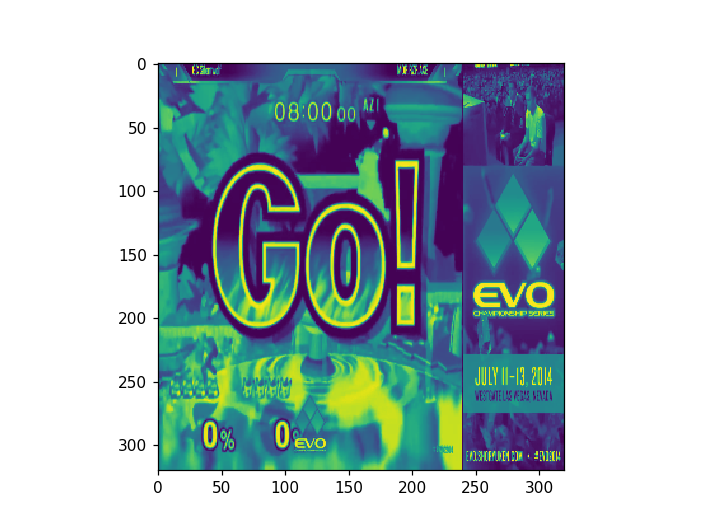

In [49]:
imshow(frames[195])

In [94]:
x = frames[600].astype(np.float) - frames[661].astype(np.float)
mask = np.zeros_like(x)
indices = x[-0.1 < x &  x > 0.1]
mask[indices] = 255
# x[x > 0] = 255
# x[x < 0] = 0
plt.imshow(mask, cmap = 'gray')

SyntaxError: invalid syntax (<ipython-input-94-e00f6f37edbf>, line 3)

/home/francesco/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


<IPython.core.display.Javascript object>


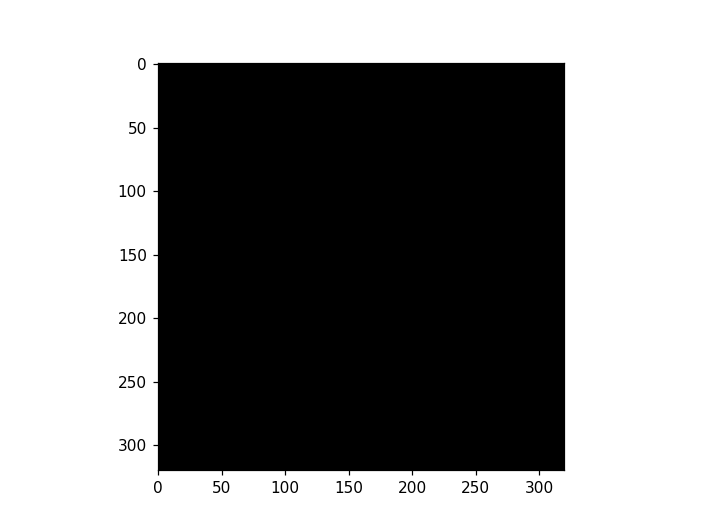

In [77]:
from skimage.measure import compare_ssim


temps = frames[190:190 + 100]
temps = list(map(lambda x: cv2.GaussianBlur(x,(5,5),0), temps))
score, diff = compare_ssim(temps[0], temps[4], full=True)
diff = (diff * 255).astype("uint8")
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# temps = list(map(lambda x: cv2.GaussianBlur(x,(3,3),0), temps))
# canvas = temps[0].copy()
# canvas = canvas.astype(np.float)
# for frame in temps:
#     canvas frame
#     canvas = cv2.normalize(canvas,  canvas, 0, 255, cv2.NORM_MINMAX)
# canvas = reduce(operator.sub, frames[190:190 + 30])
# canvas = cv2.normalize(canvas,  canvas, 0, 255, cv2.NORM_MINMAX)
# canvas[canvas >= 0] = 255
# canvas[canvas < 0] = 0
plt.imshow(thresh, cmap = 'gray')


<IPython.core.display.Javascript object>


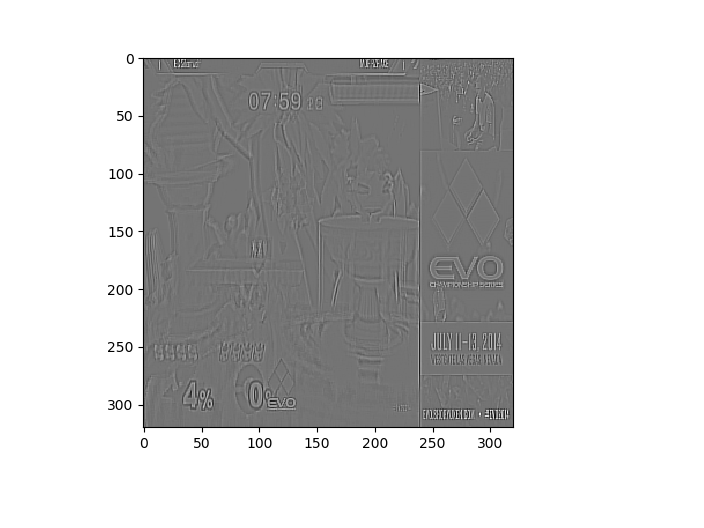

KeyboardInterrupt: 

In [177]:
from functools import reduce
import operator 
from tqdm.autonotebook import tqdm
plt.ion()
buffer_len = 4
buffer = []
canvas = None
fig = plt.figure()
tr = 100
tmps = []

for frame in tqdm(frames[180:]):
    laplacian = cv2.Laplacian(frame,cv2.CV_64F, ksize=3)
    buffer.append(laplacian)
#     tmps.append(laplacian)

    if len(buffer) >= buffer_len:
        canvas = reduce(operator.sub, buffer)
        canvas = cv2.normalize(canvas,  canvas, 0, 255, cv2.NORM_MINMAX)
        canvas = canvas.astype(np.uint8)
        tmps.append(canvas)
        plt.imshow(canvas, cmap = 'gray')
        fig.canvas.draw()

        time.sleep(0.001)
        buffer = buffer[1:]
#         break
    

In [162]:
tmps[4]

array([[ 40,   0,   4, ...,   0, 220,   0],
       [ 52,   0,   0, ...,   0,  70,   0],
       [ 44,   0,   0, ...,  90, 246,  60],
       ...,
       [ 84,   0,  14, ...,  20,  28,   0],
       [ 76,   0,  30, ...,  10,  24,   0],
       [ 72,   0,  16, ...,   0,   8,   0]], dtype=uint8)

## Find text in image
We can use something like this
[EAST: An Efficient and Accurate Scene Text Detector
](https://arxiv.org/abs/1704.03155)
### OpenCV
https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

In [52]:
from detection import TextDetector

<IPython.core.display.Javascript object>


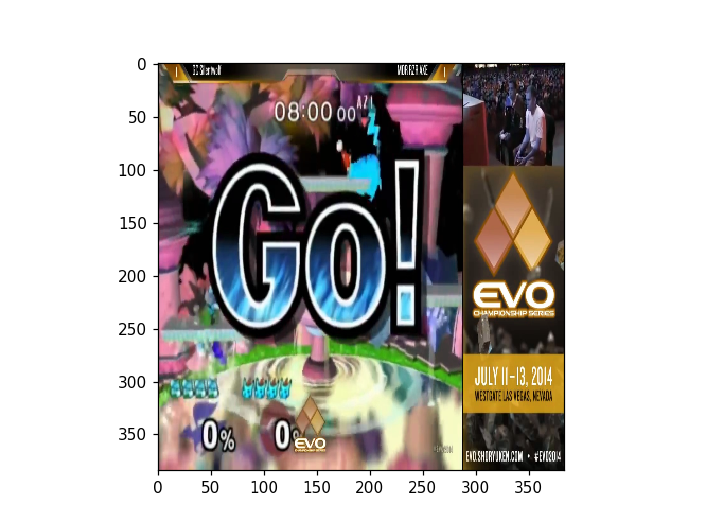

(384, 384, 3)


2019-12-05 22:45:31,059 - [INFO] - Text detection took 0.202084 seconds


In [198]:
file_path =  '/home/francesco/Documents/Kanga-Challenge/source/dataset/videos/evo2014/frames/196.jpg'

img = cv2.imread(file_path)
img_r = cv2.resize(img, (32 * 12,32 * 12))
# img_r_gr = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
# x = cv2.GaussianBlur(img_r_gr,(3,3),0)
# x = cv2.Laplacian(img_r_gr, cv2.CV_64F, ksize=3)
# x = cv2.normalize(x,  x, 0, 255, cv2.NORM_MINMAX)
# x = x.astype(np.uint8)
# x[x>120] = 0
# print(x.shape)
# x =  cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
x = img_r
_ = imshow(x)
print(x.shape)
det = TextDetector()
det([x])

In [165]:
det.boxes[3]

array([298, 281, 345, 305], dtype=uint32)

In [166]:
?? patches.Rectangle

<IPython.core.display.Javascript object>


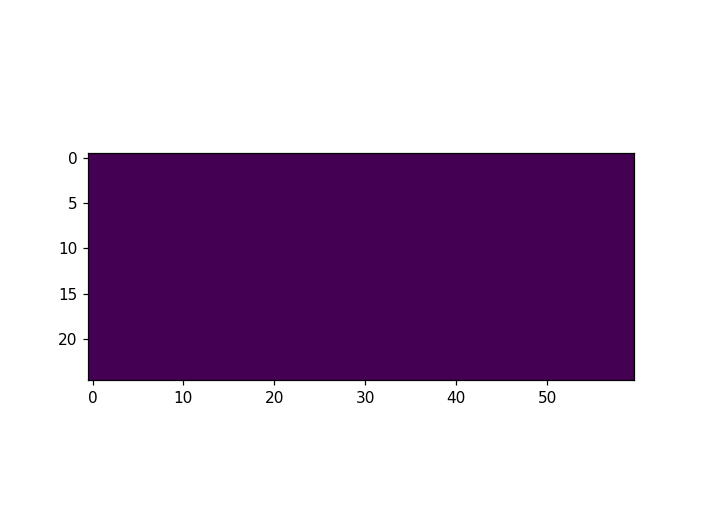

''

In [261]:
h,w,c = img_r.shape
x1, y1,x2, y2 = det.boxes[1]
tmp = img_r[y1:y2, x1:x2]
# tmp = cv2.copyMakeBorder(tmp, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
x = cv2.GaussianBlur(tmp,(3,3),0)
x = cv2.Laplacian(x, cv2.CV_64F, ksize=3)
x = cv2.normalize(x,  x, 0, 255, cv2.NORM_MINMAX)
# x = x.astype(np.uint8)
# x = cv2.resize(x, (300,200))
x[x<100] = 255
x[x>100] = 0
imshow(x)

tmp_pil = Image.fromarray(x)
# tmp_pil.show()
pytesseract.image_to_string(tmp_pil)

<IPython.core.display.Javascript object>


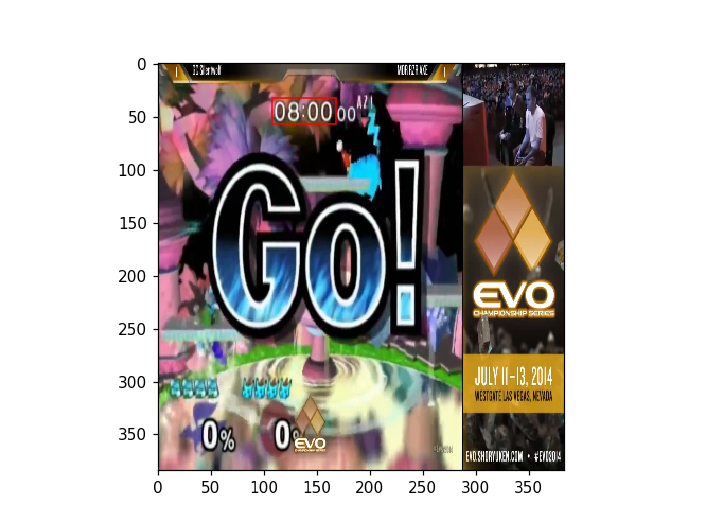

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefa27aa510>)

In [187]:
det.plot_boxes(img_r)

In [122]:
img = tmps[4]
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
H, W, c = img.shape

NameError: name 'tmps' is not defined

In [163]:

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet('/home/francesco/Documents/Kanga-Challenge/source/checkpoint/east/model.pb')
layers = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(img, 1.0, (H,W), (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layers)
end = time.time()
 
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.147269 seconds


In [164]:
scores, geometry = scores.squeeze(), geometry.squeeze()

def convert_geometry(geometry, scores, original_shape, factor=4):
    grid, _ = np.meshgrid(np.arange(original_shape[0] // 4), np.arange(original_shape[0] // 4))

    cos = np.cos(geometry[4])
    sin = np.sin(geometry[4])

    h = geometry[0] + geometry[2]
    w = geometry[1] + geometry[3]

    x2 = grid * factor + cos * geometry[1] + sin *  geometry[2]
    y2 = grid.T * factor - sin *  geometry[1] + cos *  geometry[2]
    x1 = x2 - w
    y1 = y2 - h

    indices = np.where(scores.reshape(-1) > 0.8)[0]

    boxes = np.stack([x1, y1, x2, y2])
    boxes = boxes.reshape((4, -1))
    boxes = boxes.transpose(1,0)
    boxes = boxes[indices]
    boxes = boxes.astype(np.uint32)
    confidences = scores.reshape(-1)[indices]

    return boxes, confidences, indices, (h, w)


boxes, confidences, indices, (h, w) = convert_geometry(geometry, scores, (H, W))

In [165]:
centers = np.array((0.5*(boxes[:,0]+boxes[:,2]), 0.5*(boxes[:,1]+boxes[:,3])))
centers = centers.transpose(1, 0)
angles = -1*geometry[4].flatten()[indices] * 180/np.pi
dimensions = np.array((w.flatten()[indices], h.flatten()[indices])).transpose(1, 0)
detections =[]
for center, angle, dim in zip(centers, angles, dimensions):
    detections.append(((center[0], center[1]), (dim[0],dim[1]), angle))
    

In [166]:
confThreshold = 0.5
nmsThreshold = 0.3
indices = cv2.dnn.NMSBoxesRotated(detections, confidences, confThreshold, nmsThreshold)

In [167]:
boxes = boxes[indices].squeeze()

<IPython.core.display.Javascript object>


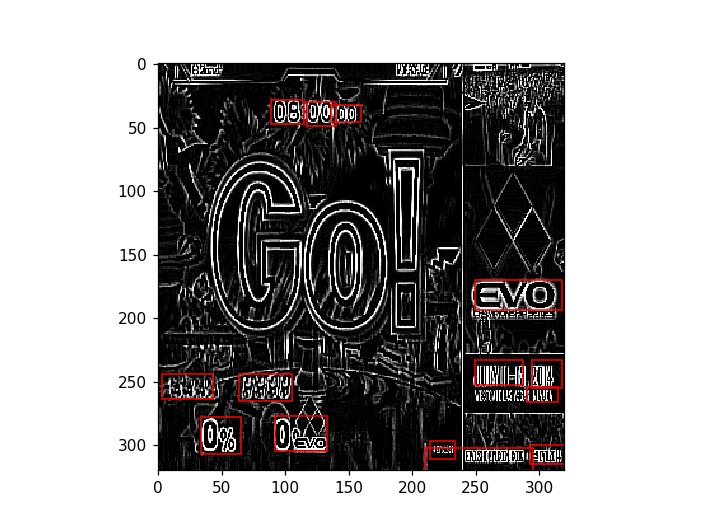

In [168]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
plt.imshow(img)

for box in boxes:
    x1,y1,x2,y2 = box
    
    rect = patches.Rectangle((x1,y1),x2 - x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

In [ ]:
from PIL import Image
import pytesseract


print(pytesseract.image_to_string(Image.open(file_path).convert('LA')))

In [ ]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
boxes = []
confidences = []
print(numRows)
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0,0,y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.9:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        boxes.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [ ]:
len(rects)

In [ ]:
rects

In [ ]:
(numRows, numCols) = scores.shape[2:4]
numRows

In [ ]:
geometry.squeeze().shape

In [ ]:
scores.squeeze()
geometry.squeeze()

In [ ]:
print(x)